In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import cv2
import open3d as o3d
import numpy as np
import pandas as pd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Evaluation Final

### Generating 3D Visualization of the Resultant Poses

In [2]:
omit_masks = [] 
is_yolo = False
image_num = 6
#rgb_path = "new_data/2025_02_27___12_37_07_239_rgb.jpg" # for image 3
#rgb_path = "new_data/2025_02_26___16_00_41_665_rgb.jpg" # for image 4
#rgb_path = "new_data/2025_02_24___13_00_01_rgb.jpg" # for image 5
rgb_path = "new_data/2025_02_25___15_32_18_rgb.jpg" # for image 6
#rgb_path = "new_data/2025_03_04___12_36_32_642_rgb.jpg" # for image 7


In [3]:
# strip off the "_rgb" suffix (and extension) to get the common base
base = rgb_path.rsplit("_rgb", 1)[0]
depth_path      = base + "_depth.png"
yolo_csv_path   = base + "poses_bboxes.csv"   # matches "...15poses_bboxes.csv"
info_csv_path   = base + "_request.csv"

yolo_csv_path = f"obj_FINAL1_evaluation/image_{image_num}/poses_and_bboxes.csv" if not is_yolo else yolo_csv_path
save_dir = f"obj_FINAL1_evaluation/image_{image_num}/"

print("RGB  :", rgb_path)
print("Depth:", depth_path)
print("YOLO :", yolo_csv_path)
print("Info :", info_csv_path)

# print width and height of the image
img = cv2.imread(rgb_path)
h, w = img.shape[:2]
print(f"Image dimensions: {w} x {h}")


color = o3d.io.read_image(rgb_path)
depth = o3d.io.read_image(depth_path)

# Create RGBD image (adjust depth_scale and depth_trunc as needed)
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color, 
    depth, 
    depth_scale=1000.0, 
    depth_trunc=3.0, 
    convert_rgb_to_intensity=False
)

flip = np.array([[ 1,  0,  0, 0],
                 [ 0, -1,  0, 0],
                 [ 0,  0, -1, 0],
                 [ 0,  0,  0, 1]])

# 3×3 part for rotating frames or boxes
Rflip = flip[:3, :3]

# --- Generate point cloud ---
# your intrinsics
cam_intrinsics = [729.7567138671875, 729.7567138671875,
                  965.4871826171875, 553.424072265625]
fx, fy, cx, cy = cam_intrinsics

# construct custom pinhole intrinsic
intrinsic = o3d.camera.PinholeCameraIntrinsic(
    w, h,
    fx, fy, cx, cy
)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic, )
# Optionally flip the point cloud for correct orientation
pcd.transform(flip)

# --- Load grasp poses and bounding boxes from CSV ---
# read out all the columns except the first one if is_yolo is False

# —– loading your YOLO-style CSV —–
df = pd.read_csv(yolo_csv_path)
# if not is_yolo:
#     # drop the first column, whatever it’s called
#     df = df.drop(columns=['MaskNum'])

# prepare scene list
geoms = [pcd]

T_top = np.load("obj_FINAL1_data/permanent_data/top_view_frame_transform.npy")

# create and place the frame
frame_top = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
frame_top.transform(T_top)
frame_top.transform(flip)
geoms.append(frame_top)

label_spheres = []
label_colors = []  # optional, in case you want per-label colors
mask_ids = []      # to store mask numbers for later rendering

counter = -1
for _, row in df.iterrows():

    # if mask number is in omit_masks, skip this row
    if row['MaskNum'] in omit_masks:
        continue

    # — translation —
    t = np.array([row['Pose_Cam_X'],
                  row['Pose_Cam_Y'],
                  row['Pose_Cam_Z']])

    # — corrected quaternion —
    quat = [
        row['Pose_Cam_Ori_W'],  # W
        row['Pose_Cam_Ori_X'],  # X
        row['Pose_Cam_Ori_Y'],  # Y
        row['Pose_Cam_Ori_Z']   # Z
    ]
    R_grasp = o3d.geometry.get_rotation_matrix_from_quaternion(quat)

    # ── INSERT THIS TO FIX Z‐FLIP  ──
    if not is_yolo:
        # flip the local Z axis so it points outwards instead of into the box
        Fz = np.diag([1.0, 1.0, -1.0])
        R_grasp = R_grasp @ Fz
    # ────────────────────────────────────────────────

    # — build and place the frame —
    T = np.eye(4)
    T[:3, :3] = R_grasp
    T[:3,  3] = t

     # —— offset along the grasp’s local Z so frames float in front of the cloud
    offset = 0.01                     # 2 cm, adjust as needed
    local_z = T[:3, 2]                # the 3rd column of R is the frame’s Z axis
    T[:3, 3] += offset * local_z     # shift the origin along local Z

    frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    frame.transform(T)
    frame.transform(flip)    # keep your flip in place
    geoms.append(frame)


    # --- oriented bounding box, Option A ---
    center_cam = np.array([
        row['BBox_Cam_Center_X'],
        row['BBox_Cam_Center_Y'],
        row['BBox_Cam_Center_Z']])
    extent = np.array([
        row['BBox_Cam_Extent_X'],
        row['BBox_Cam_Extent_Y'],
        row['BBox_Cam_Extent_Z']])
    R_cam = np.array([
        [row['BBox_Cam_R00'], row['BBox_Cam_R01'], row['BBox_Cam_R02']],
        [row['BBox_Cam_R10'], row['BBox_Cam_R11'], row['BBox_Cam_R12']],
        [row['BBox_Cam_R20'], row['BBox_Cam_R21'], row['BBox_Cam_R22']]])

    # flipping
    center_flipped = Rflip @ center_cam
    R_flipped      = Rflip @ R_cam

    obb = o3d.geometry.OrientedBoundingBox(
    center_flipped,
    R_flipped,
    extent
    )
    obb.color = np.random.rand(3)
    geoms.append(obb)

    if not is_yolo:
        # Extract mask number directly from the CSV
        mask_id = row['MaskNum']
        # — Compute translation and orientation —
        t = np.array([row['Pose_Cam_X'], row['Pose_Cam_Y'], row['Pose_Cam_Z']])
        quat = [row['Pose_Cam_Ori_W'], row['Pose_Cam_Ori_X'], row['Pose_Cam_Ori_Y'], row['Pose_Cam_Ori_Z']]
        R_pose = o3d.geometry.get_rotation_matrix_from_quaternion(quat)
        # Flip Z axis for correct orientation (for optimizer)
        R_pose = R_pose @ np.diag([1.0, 1.0, -1.0])
        # Offset label 10 cm in negative local X direction
        label_pos = t - 0.10 * R_pose[:, 0]
        # Apply global flip for visualization
        label_pos = Rflip @ label_pos
        # Create small yellow sphere as label marker
        label_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.05)
        label_sphere.paint_uniform_color([1.0, 1.0, 0.0])  # Yellow
        label_sphere.translate(label_pos)
        label_spheres.append((label_sphere, mask_id))

# Add spheres to geometry list
#geoms.extend(label_spheres)


# create camera frame at the origin
camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
camera_frame.transform(flip) # only for correct visualization
geoms.append(camera_frame)

# --- Visualize all geometries ---
#o3d.visualization.draw_geometries(geoms)

if is_yolo:
    save_img_file1 = save_dir + "top_view_snapshot_yolo.png"
    save_img_file2 = save_dir + "camera_view_snapshot_yolo.png"
else:
    save_img_file1 = save_dir + "top_view_snapshot_optimizer.png"
    save_img_file2 = save_dir + "camera_view_snapshot_optimizer.png"

# --- OFFSCREEN RENDER & COLORED SNAPSHOT ---
vis = o3d.visualization.Visualizer()
vis.create_window(width=1930, height=1930, visible=False)
# dark BG
opt = vis.get_render_option()
opt.background_color = np.array([0.5, 0.5, 0.5])
opt.point_size = 2.0
# 1) add the colored point cloud
vis.add_geometry(pcd)
vis.update_geometry(pcd)
# 2) add all grasp‐pose frames & boxes, but skip the top‐view arrow
for g in geoms:
    if g is frame_top or g is camera_frame:
        continue
    vis.add_geometry(g)
    vis.update_geometry(g)
# 3) set view to your saved top‐view pose
ctr = vis.get_view_control()
param = ctr.convert_to_pinhole_camera_parameters()
cam2world_top = flip @ T_top
param.extrinsic = np.linalg.inv(cam2world_top)
ctr.convert_from_pinhole_camera_parameters(param)
# 4) render & capture
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image(save_img_file1, do_render=True)

# now capture original camera-frame view
# reset extrinsic to identity (camera at world origin)
# flip the camera frame to match the point cloud
param.extrinsic = flip @ np.eye(4)
ctr.convert_from_pinhole_camera_parameters(param)

# re-render and grab
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image(save_img_file2, do_render=True)

vis.destroy_window()

# load the saved image
img = cv2.imread(save_img_file1)
#img2 = cv2.imread(save_img_file2)
# rotate 180° (flip both axes)
img_rot = cv2.flip(img, -1)
#img2_rot = cv2.flip(img2, -1)
# overwrite the snapshot with the rotated version
cv2.imwrite(save_img_file1, img_rot)
#cv2.imwrite(save_img_file2, img2_rot)
print("Saved camera view and top view snapshots.")

RGB  : new_data/2025_02_25___15_32_18_rgb.jpg
Depth: new_data/2025_02_25___15_32_18_depth.png
YOLO : obj_FINAL1_evaluation/image_6/poses_and_bboxes.csv
Info : new_data/2025_02_25___15_32_18_request.csv
Image dimensions: 1920 x 1080
Saved camera view and top view snapshots.


In [3]:
# Reload the rotated image
img = cv2.imread(save_img_file1)

# Image size for flipping coords
img_h, img_w = img.shape[:2]

# Projection matrix
intrinsic_matrix = np.array([[fx, 0, cx],
                             [0, fy, cy],
                             [0,  0,  1]])

offset_y = 0.05  # 5 cm offset upwards in camera frame

for i, (sphere, mask_id) in enumerate(label_spheres):
    label_3d = np.asarray(sphere.get_axis_aligned_bounding_box().get_center())

    label_3d_cam = np.linalg.inv(flip @ T_top) @ np.append(label_3d, 1.0)
    label_3d_cam = label_3d_cam[:3]

    label_3d_cam[1] += offset_y

    if label_3d_cam[2] > 0:
        x, y = (intrinsic_matrix @ label_3d_cam.reshape(3, 1)).flatten()[:2] / label_3d_cam[2]

        # Flip pixel coordinates to compensate image flip (rotated 180 degrees)
        x_flipped = img_w - int(x)
        y_flipped = img_h - int(y)

        cv2.putText(img,
                    str(mask_id),
                    (x_flipped, y_flipped),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, (0, 0, 255), 2, cv2.LINE_AA)

cv2.imwrite(save_img_file1 + "_labeled.png", img)
print("✅ Labels rendered and snapshot saved with text overlays.")



NameError: name 'save_img_file1' is not defined

In [11]:
import os
max_mask = 11

def ScaleMask(masks, im0_shape, ratio_pad=None):
    im1_shape = masks.shape
    if im1_shape[:2] == im0_shape[:2]:
        return masks
    if ratio_pad is None:
        gain = min(im1_shape[0] / im0_shape[0], im1_shape[1] / im0_shape[1])
        pad = (im1_shape[1] - im0_shape[1] * gain) / 2, (im1_shape[0] - im0_shape[0] * gain) / 2
    else:
        pad = ratio_pad[1]
    top, left = int(pad[1]), int(pad[0])
    bottom, right = int(im1_shape[0] - pad[1]), int(im1_shape[1] - pad[0])

    if len(masks.shape) < 2:
        raise ValueError("mask shape must be 2D or 3D")

    masks = masks[top:bottom, left:right]
    masks = cv2.resize(masks, (im0_shape[1], im0_shape[0]))
    if len(masks.shape) == 2:
        masks = masks[:, :, None]
    return masks

def ViewSegments(rgb_img_or_array, mask, mask_num=None, blend_value=0.4,
                 show=True, save=False, debug=False, image_out=None):
    if isinstance(rgb_img_or_array, str):
        image = cv2.imread(rgb_img_or_array)
    else:
        image = rgb_img_or_array.copy()

    if image_out is None:
        image_out = image.copy()

    if len(mask.shape) == 3 and mask.shape[2] == 1:
        mask = mask[:, :, 0]

    scaled_mask = ScaleMask(mask, image.shape)
    binary_mask = (scaled_mask > 0.5).astype(np.uint8)  # Thresholding to avoid faint overlays

    # Create a colored mask using COLORMAP_JET only on the binary mask
    colored_mask = cv2.applyColorMap((binary_mask * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Only blend where the mask is active
    overlay = image_out.copy()
    mask_indices = binary_mask.astype(bool)
    overlay[mask_indices] = cv2.addWeighted(image_out[mask_indices], 1 - blend_value,
                                            colored_mask[mask_indices], blend_value, 0)

    image_out = overlay

    if mask_num is not None:
        M = cv2.moments(binary_mask.astype(np.uint8))
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.putText(image_out, str(mask_num), (cX, cY),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2, cv2.LINE_AA)

    if show:
        image_rgb = cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

    if save:
        cv2.imwrite("data/segmented_image_labeled.jpg", image_out)

    return binary_mask, image_out

# Load original image
image_path = rgb_path
image = cv2.imread(image_path)

# Load YOLO masks
masks_dir = f"obj_FINAL1_data/permanent_data/YOLO_results/image_{image_num}"

# Copy the original image for visualization
image_viz = image.copy()

# Loop over masks
for i in range(max_mask):
    if i not in [4, 10]:
        continue
    mask = np.load(os.path.join(masks_dir, f"mask_{i}.npy"))
    _, image_viz = ViewSegments(image, mask, mask_num=i, show=False, image_out=image_viz)

# Final display
plt.imshow(cv2.cvtColor(image_viz, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Save the final result
cv2.imwrite("data/segmented_image_final.jpg", image_viz)


IndexError: boolean index did not match indexed array along dimension 2; dimension is 3 but corresponding boolean dimension is 1

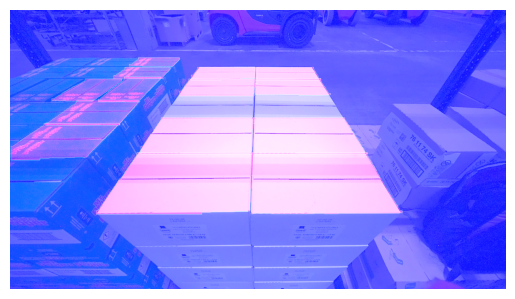

In [18]:
max_mask = 27

def ScaleMask(masks, im0_shape, ratio_pad=None):
    """
    Takes a mask, and resizes it to the original image size.
    Inputs:
        1. masks (np.ndarray): Resized and padded masks/images, [h, w, num]/[h, w, 3].
        2. im0_shape (tuple): The original image shape.
        3. ratio_pad (tuple): The ratio of the padding to the original image.
    Returns:
        masks (np.ndarray): The masks that are being returned with shape [h, w, num].
    """
    # Rescale coordinates (xyxy) from im1_shape to im0_shape
    im1_shape = masks.shape
    if im1_shape[:2] == im0_shape[:2]:
        return masks
    if ratio_pad is None:  # calculate from im0_shape
        gain = min(im1_shape[0] / im0_shape[0], im1_shape[1] / im0_shape[1])  # gain  = old / new
        pad = (im1_shape[1] - im0_shape[1] * gain) / 2, (im1_shape[0] - im0_shape[0] * gain) / 2  # wh padding
    else:
        # gain = ratio_pad[0][0]
        pad = ratio_pad[1]
    top, left = int(pad[1]), int(pad[0])  # y, x
    bottom, right = int(im1_shape[0] - pad[1]), int(im1_shape[1] - pad[0])

    if len(masks.shape) < 2:
        raise ValueError(f'"len of masks shape" should be 2 or 3, but got {len(masks.shape)}')
    masks = masks[top:bottom, left:right]
    masks = cv2.resize(masks, (im0_shape[1], im0_shape[0]))
    if len(masks.shape) == 2:
        masks = masks[:, :, None]

    return masks

def ViewSegments(rgb_img_or_array, mask, mask_num=None, blend_value=0.3,
                 show=True, save=False, debug=False, image_out=None):
    """
    Visualize and label the segmentation on the image.

    Args:
        rgb_img_or_array (str or np.ndarray): Path to the RGB image or already-loaded image.
        mask (np.ndarray): Binary mask (0/1) of the segmentation.
        mask_num (int or str): The label number to display on the segmentation.
        blend_value (float): Transparency for overlay.
        show (bool): Show the image with matplotlib.
        save (bool): Save final image to disk (only works when image_out is not None).
        debug (bool): Verbose output.
        image_out (np.ndarray): Existing image to draw over; if None, starts from original image.

    Returns:
        updated_mask (np.ndarray): Scaled mask.
        image_out (np.ndarray): Image with blended overlay and label.
    """
    # Load image if string path is provided
    if isinstance(rgb_img_or_array, str):
        image = cv2.imread(rgb_img_or_array)
    else:
        image = rgb_img_or_array.copy()

    if image_out is None:
        image_out = image.copy()

    if len(mask.shape) == 3 and mask.shape[2] == 1:
        mask = mask[:, :, 0]
    if debug:
        print("Mask shape:", mask.shape)

    # Resize mask if needed
    scaled_mask = ScaleMask(mask, image.shape)  # Custom function, assumed available

    # Colorize the mask and blend it
    colored_mask = cv2.applyColorMap((scaled_mask * 255).astype(np.uint8), cv2.COLORMAP_JET)
    image_out = cv2.addWeighted(image_out, 1.0, colored_mask, blend_value, 0)

    # Add label at center of segmentation
    if mask_num is not None:
        # Get centroid of the mask
        M = cv2.moments(scaled_mask.astype(np.uint8))
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            #cv2.putText(image_out, str(mask_num), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 2, cv2.LINE_AA)

    # Show image
    if show:
        image_rgb = cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

    # Save image if requested
    if save:
        cv2.imwrite("data/segmented_image_labeled.jpg", image_out)

    return scaled_mask, image_out

image_path = rgb_path
image = cv2.imread(image_path)

masks_dir = f"obj_FINAL1_data/permanent_data/YOLO_results/image_{image_num}"

# Loop over multiple masks
for i in range(max_mask):
    if i not in [1, 3, 12, 18, 19, 22, 26, 20, 0, 4, 6, 10, 15, 7]:
        continue
    mask = np.load(masks_dir + f"/mask_{i}.npy")
    _, image = ViewSegments(image, mask, mask_num=i, show=False, image_out=image, blend_value=0.8)


# Show final result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Save final result
#cv2.imwrite("data/segmented_image_final.jpg", image)

# masks: 4, 5, 6, 7, 9, 12, 13, 14, 15, 16, 24, 27, 30, 39 # for image 7
# masks: 0, 1, 3, 4, 6, 7, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 22, 26

In [6]:
import cv2
import numpy as np

# Define the mask numbers you want to label with
mask_num = [1, 3, 12, 18, 19, 22, 26, 20, 0, 4, 6, 10, 15, 7]

# Load your image
image_path = save_img_file1
save_img_path = save_img_file1 + "_labeled.png"
save_points_path = save_img_file1 + "_clicked_points.txt"

img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {image_path}")
img_draw = img.copy()

clicked_points = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        index = len(clicked_points)
        if index < len(mask_num):
            label = mask_num[index]
            clicked_points.append((x, y))

            # Draw the label text instead of index
            cv2.putText(img_draw, str(label), (x + 10, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
            cv2.imshow("Click Points", img_draw)
        else:
            print("⚠️ You have already clicked for all mask numbers.")

cv2.namedWindow("Click Points")
cv2.setMouseCallback("Click Points", click_event)

print("Click on the image. Press 'q' to finish.")
while True:
    cv2.imshow("Click Points", img_draw)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

# Save the image and clicked points
cv2.imwrite(save_img_path, img_draw)
np.savetxt(save_points_path, clicked_points, fmt="%d", delimiter=",")
print(f"✅ Saved labeled image: {save_img_path}")
print(f"🧾 Saved clicked points: {save_points_path}")


Click on the image. Press 'q' to finish.
✅ Saved labeled image: obj_FINAL1_evaluation/image_6/top_view_snapshot_optimizer.png_labeled.png
🧾 Saved clicked points: obj_FINAL1_evaluation/image_6/top_view_snapshot_optimizer.png_clicked_points.txt


In [5]:
# run this one time only to save new clicked points!

import cv2

# Load your image
image_path = save_img_file1 
save_img_path = save_img_file1 + "_labeled.png"
save_points_path = save_img_file1 + "_clicked_points.txt"
# image_path = save_img_file2  

img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {image_path}")
img_draw = img.copy()

clicked_points = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        index = len(clicked_points)
        clicked_points.append((x, y))

        #cv2.circle(img_draw, (x, y), 5, (0, 255, 0), -1)
        cv2.putText(img_draw, str(index), (x + 10, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        cv2.imshow("Click Points", img_draw)

cv2.namedWindow("Click Points")
cv2.setMouseCallback("Click Points", click_event)

print("Click on the image. Press 'q' to finish.")
while True:
    cv2.imshow("Click Points", img_draw)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

# Save image and points
cv2.imwrite(save_img_path, img_draw)
np.savetxt(save_points_path, clicked_points, fmt="%d", delimiter=",")
print(f"✅ Saved image: {save_img_path}")
print(f"🧾 Saved points: {save_points_path}")

Click on the image. Press 'q' to finish.
✅ Saved image: obj_FINAL1_evaluation/image_6/top_view_snapshot_optimizer.png_labeled.png
🧾 Saved points: obj_FINAL1_evaluation/image_6/top_view_snapshot_optimizer.png_clicked_points.txt


In [4]:
# run this for either optimizer or yolo image

# Paths
image_path = save_img_file1
save_path = save_img_file1 + "_labeled.png"
points_path = f"obj_FINAL1_evaluation/image_{image_num}/top_view_snapshot_optimizer.png_clicked_points.txt"

# Load image and points
img = cv2.imread(image_path)
points = np.loadtxt(points_path, delimiter=",", dtype=int)

# Draw labels
for idx, (x, y) in enumerate(points):
    #cv2.circle(img, (x, y), 5, (0, 255, 0), -1)
    cv2.putText(img, str(idx), (x + 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

# Save or show
cv2.imwrite(save_path, img)
print("Annotated image saved.")

Annotated image saved.


### Processing the Records.json

In [ ]:
# run this and use it only if the records.json files look correct
import os
import json
import csv

# Define your save_dir path
save_dir = f"obj_FINAL1_evaluation/image_{image_num}/"

# Desired CSV output path
csv_path = os.path.join(save_dir, "summary_records.csv")

# Columns of interest
csv_columns = [
    "mask_number",
    "final_E_line",
    "final_E_plane",
    "final_E_pose",
    "final_E_centroids",
    "final_E_total",
    "time_duration",
    "is_vertical",
    "canny",
    "contour_noise"
]

# Create CSV and write header
with open(csv_path, mode="w", newline="") as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=csv_columns)
    writer.writeheader()

    # Iterate over all subfolders starting with "mask_"
    for folder_name in os.listdir(save_dir):
        #print(folder_name)
        if folder_name.startswith("mask_"):
            folder_path = os.path.join(save_dir, folder_name)
            #print(folder_path)
            json_path = folder_path + "/records.json"
            #print(json_path)

            if os.path.isfile(json_path):
                with open(json_path, "r") as f:
                    data = json.load(f)

                # Ensure the JSON contains a list with one dict
                if isinstance(data, list) and len(data) == 1:
                    record = data[0]

                    # Prepare the row
                    row = {
                        "mask_number": record.get("mask_number"),
                        "final_E_line": record.get("final_E_line"),
                        "final_E_plane": record.get("final_E_plane"),
                        "final_E_pose": record.get("final_E_pose"),
                        "final_E_centroids": record.get("final_E_centroids"),
                        "final_E_total": record.get("final_E_total"),
                        "time_duration": record.get("time_duration"),
                        "is_vertical": record.get("is_vertical"),
                        "canny": record.get("canny"),
                        "contour_noise": record.get("contour_noise")
                    }

                    writer.writerow(row)
                
                else:
                    print(f"Warning: JSON file {json_path} does not contain the expected format.")
            else:
                print(f"Warning: JSON file {json_path} does not exist.")

In [ ]:
# this is for taking values directly from the optimizer log csv files
import os
import csv
import pandas as pd

# Define your save_dir path
save_dir = os.path.join("obj_FINAL1_evaluation", f"image_{image_num}")

# Desired CSV output path
csv_path = os.path.join(save_dir, "summary_records.csv")

# Columns of interest
csv_columns = [
    "mask_number",
    "final_E_line",
    "final_E_plane",
    "final_E_pose",
    "final_E_centroids",
    "final_E_total",
    "time_duration",
    "is_vertical",
    "canny",
    "contour_noise"
]

# Create CSV and write header
with open(csv_path, mode="w", newline="") as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=csv_columns)
    writer.writeheader()

    # Iterate over all subfolders starting with "mask_"
    for folder_name in os.listdir(save_dir):
        if folder_name.startswith("mask_"):
            folder_path = os.path.join(save_dir, folder_name)
            log_csv_path = os.path.join(folder_path, "optimizer_log.csv")
            metadata_path = os.path.join(folder_path, "records.json")  # Use only for metadata fields

            if not os.path.isfile(log_csv_path):
                print(f"Warning: {log_csv_path} does not exist.")
                continue

            if not os.path.isfile(metadata_path):
                print(f"Warning: {metadata_path} does not exist.")
                continue

            # Read the optimizer log and extract the last row values
            try:
                df = pd.read_csv(log_csv_path)

                if not df.empty:
                    last_row = df.iloc[-1]  # Last iteration

                    with open(metadata_path, "r") as f:
                        metadata = json.load(f)[0]  # Expecting a list with one dict

                    row = {
                        "mask_number": int(folder_name.split("_")[-1]),
                        "final_E_line": float(last_row.get("E_line", 0)),
                        "final_E_plane": float(last_row.get("E_plane", 0)),
                        "final_E_pose": float(last_row.get("E_pose", 0)),
                        "final_E_centroids": float(last_row.get("E_centroids", 0)),
                        "final_E_total": float(last_row.get("E_total", 0)),
                        "time_duration": metadata.get("time_duration"),
                        "is_vertical": metadata.get("is_vertical"),
                        "canny": metadata.get("canny"),
                        "contour_noise": metadata.get("contour_noise")
                    }

                    writer.writerow(row)

            except Exception as e:
                print(f"❌ Error processing {folder_path}: {e}")


In [7]:
#this is for short summary csv file
import os
import csv
import json
import pandas as pd

mask_nums = [1, 20, 3, 26, 22, 12, 19, 18, 4, 6, 7, 10, 15, 0]

save_dir = f"obj_FINAL1_evaluation/image_{image_num}/"  # make sure image_num is defined

csv_path = os.path.join(save_dir, "short_summary.csv")

csv_columns = [
    "mask_number",
    "E_line",
    "E_plane",
    "E_pose",
    "E_total",
    "time_duration"
]

with open(csv_path, mode="w", newline="") as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=csv_columns)
    writer.writeheader()

    for mask_num in mask_nums:
        folder_name_prefix = f"mask_{mask_num}"
        # Find the folder starting with this prefix
        mask_folders = [f for f in os.listdir(save_dir) if f.startswith(folder_name_prefix)]
        
        if not mask_folders:
            print(f"Warning: No folder found for mask {mask_num} in {save_dir}")
            continue

        # Assuming only one folder per mask_num
        folder_name = mask_folders[0]
        folder_path = os.path.join(save_dir, folder_name)

        log_csv_path = os.path.join(folder_path, "optimizer_log.csv")
        json_path = os.path.join(folder_path, "records.json")

        if not os.path.isfile(log_csv_path):
            print(f"Warning: optimizer_log.csv not found for mask {mask_num} in {folder_path}")
            continue
        if not os.path.isfile(json_path):
            print(f"Warning: records.json not found for mask {mask_num} in {folder_path}")
            continue

        try:
            # Read last row from optimizer_log.csv
            df = pd.read_csv(log_csv_path)
            last_row = df.iloc[-1]

            # Load records.json and get time_duration (assumes list with one dict)
            with open(json_path, "r") as f:
                metadata = json.load(f)[0]

            row = {
                "mask_number": mask_num,
                "E_line": f"{float(last_row['E_line'])}",
                "E_plane": f"{float(last_row['E_plane'])}",
                "E_pose": f"{float(last_row['E_pose'])}",
                "E_total": f"{float(last_row['E_total'])}",
                "time_duration": metadata.get("time_duration", "NA")
            }

            writer.writerow(row)

        except Exception as e:
            print(f"Error processing mask {mask_num}: {e}")

print(f"✅ Saved summary CSV: {csv_path}")


✅ Saved summary CSV: obj_FINAL1_evaluation/image_6/short_summary.csv


In [ ]:
# this is for summary records.csv file
import pandas as pd
from IPython.display import display, HTML

csv_path = "obj_FINAL1_evaluation/image_6/summary_records.csv"
# Read the summary_records.csv file
summary_df = pd.read_csv(csv_path)

summary_df = summary_df.sort_values("mask_number").reset_index(drop=True)
# drop all rows where mask number is from mask_nums list 
#mask_num = [1, 3, 12, 18, 19, 22, 26, 20, 0, 4, 6, 10, 15, 7] # masks to include
#summary_df = summary_df[summary_df["mask_number"].isin(mask_num)].reset_index(drop=True)

# Select and rename columns for the thesis table
thesis_table = summary_df[["mask_number", "final_E_line", "final_E_plane", "final_E_pose", "final_E_total", "time_duration"]].copy()
thesis_table.columns = ["Mask", "E_Line(1e-6)", "E_Plane(1e-6)", "E_Pose(1e-6)" ,"E_Total(1e-6)", "Time Duration(s)"]


# Multiply error columns by 1e6 for presentation
for col in ["E_Line(1e-6)", "E_Plane(1e-6)", "E_Pose(1e-6)", "E_Total(1e-6)"]:
    thesis_table[col] = thesis_table[col] * 1e6

latex_code = thesis_table.to_latex(index=False, caption="Error Breakdown and Time Duration of Optimization for Each Box", label="tab:eval1equalweights2")
print(latex_code)

# Format the table for display
styled_table = thesis_table.style.format({
    "E_Line(1e-6)": "{:.2f}",
    "E_Plane(1e-6)": "{:.2f}",
    "E_Pose(1e-6)": "{:.2f}",
    "E_Total(1e-6)": "{:.2f}",
    "Time Duration(s)": "{:.3f}"
}).set_table_styles([
    {"selector": "th", "props": [("font-size", "110%"), ("text-align", "center")]},
    {"selector": "td", "props": [("text-align", "center")]}
]).set_caption("Summary of Optimizer Results")

display(styled_table)

avg_time = thesis_table["Time Duration(s)"].mean()
print(f"Average Time Duration: {avg_time:.3f} seconds")


KeyError: "['final_E_line', 'final_E_plane', 'final_E_pose', 'final_E_total'] not in index"

In [24]:
# this is for short summary.csv file
import pandas as pd
from IPython.display import display, HTML

csv_path = "obj_FINAL1_evaluation/image_6/Eval3_unknow_dims1/short_summary_manual.csv"
# Read the summary_records.csv file
summary_df = pd.read_csv(csv_path)

summary_df = summary_df.sort_values("mask_number").reset_index(drop=True)
# drop all rows where mask number is from mask_nums list 
#mask_num = [1, 3, 12, 18, 19, 22, 26, 20, 0, 4, 6, 10, 15, 7] # masks to include
#summary_df = summary_df[summary_df["mask_number"].isin(mask_num)].reset_index(drop=True)

# drop rows if mask_number is in omit_masks 
# omit_masks = [0, 4, 6, 7, 10, 15]
# summary_df = summary_df[~summary_df["mask_number"].isin(omit_masks)].reset_index(drop=True)

# Select and rename columns for the thesis table
thesis_table = summary_df[["mask_number", "E_line", "E_plane", "E_pose", "E_total", "time_duration"]].copy()
thesis_table.columns = ["Mask", "E_Line(1e-6)", "E_Plane(1e-6)", "E_Pose(1e-6)" ,"E_Total(1e-6)", "Time Duration(s)"]


# Multiply error columns by 1e6 for presentation
for col in ["E_Line(1e-6)", "E_Plane(1e-6)", "E_Pose(1e-6)", "E_Total(1e-6)"]:
    thesis_table[col] = thesis_table[col] * 1e6

latex_code = thesis_table.to_latex(index=False, caption="Error Breakdown and Time Duration of Optimization for Each Box", label="tab:eval1equalweights2")
print(latex_code)

# Format the table for display
styled_table = thesis_table.style.format({
    "E_Line(1e-6)": "{:.2f}",
    "E_Plane(1e-6)": "{:.2f}",
    "E_Pose(1e-6)": "{:.2f}",
    "E_Total(1e-6)": "{:.2f}",
    "Time Duration(s)": "{:.3f}"
}).set_table_styles([
    {"selector": "th", "props": [("font-size", "110%"), ("text-align", "center")]},
    {"selector": "td", "props": [("text-align", "center")]}
]).set_caption("Summary of Optimizer Results")

display(styled_table)

avg_time = thesis_table["Time Duration(s)"].mean()
print(f"Average Time Duration: {avg_time:.3f} seconds")


\begin{table}
\caption{Error Breakdown and Time Duration of Optimization for Each Box}
\label{tab:eval1equalweights2}
\begin{tabular}{rrrrrr}
\toprule
Mask & E_Line(1e-6) & E_Plane(1e-6) & E_Pose(1e-6) & E_Total(1e-6) & Time Duration(s) \\
\midrule
0 & 58.300000 & 1.270000 & 0.021600 & 11.900000 & 3.268838 \\
1 & 23.500000 & 1.430000 & 0.024600 & 5.000000 & 3.628403 \\
3 & 6.570000 & 0.943000 & 0.021800 & 1.520000 & 3.183047 \\
4 & 55.700000 & 0.840000 & 0.009870 & 11.300000 & 3.321904 \\
6 & 30.700000 & 1.120000 & 0.000651 & 6.360000 & 2.849693 \\
7 & 159.364000 & 116.645000 & 0.437000 & 55.500000 & 3.593453 \\
10 & 49.800000 & 1.590000 & 0.039100 & 10.300000 & 3.628403 \\
12 & 49.800000 & 1.590000 & 0.039100 & 10.300000 & 5.807869 \\
15 & 28.600000 & 1.930000 & 0.001060 & 6.110000 & 2.518087 \\
18 & 28.600000 & 1.930000 & 0.001060 & 6.110000 & 4.201378 \\
19 & 7.180000 & 1.780000 & 0.004460 & 1.790000 & 3.671402 \\
20 & 29.500000 & 1.700000 & 0.040600 & 6.270000 & 1.922533 \\
22 & 3.

,Mask,E_Line(1e-6),E_Plane(1e-6),E_Pose(1e-6),E_Total(1e-6),Time Duration(s)
0,0,58.30,1.27,0.02,11.90,3.269
1,1,23.50,1.43,0.02,5.00,3.628
2,3,6.57,0.94,0.02,1.52,3.183
3,4,55.70,0.84,0.01,11.30,3.322
4,6,30.70,1.12,0.00,6.36,2.850
5,7,159.36,116.65,0.44,55.50,3.593
6,10,49.80,1.59,0.04,10.30,3.628
7,12,49.80,1.59,0.04,10.30,5.808
8,15,28.60,1.93,0.00,6.11,2.518
9,18,28.60,1.93,0.00,6.11,4.201


Average Time Duration: 3.267 seconds


C:\Users\Startklar\AppData\Local\Temp\ipykernel_29888\946177014.py:72: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


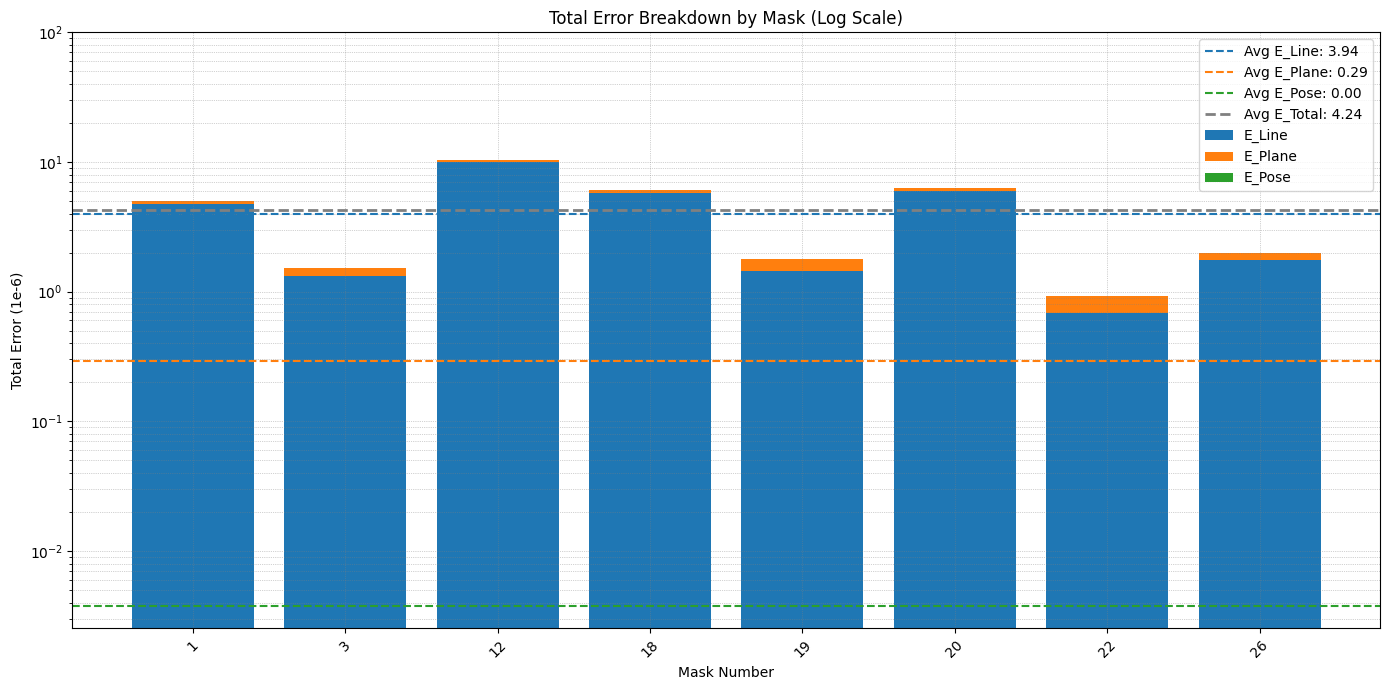

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Define your save_dir path
#save_dir = f"obj_FINAL1_evaluation/image_{image_num}/"
# Desired CSV output path
#csv_path = os.path.join(save_dir, "summary_records.csv")

#csv_path = "obj_FINAL1_evaluation/image_3/Eval1_tunedweights1/summary_records.csv"
#csv_path = "obj_FINAL1_evaluation/image_5/Eval2_weights1_contouradjustedweights1/summary_records.csv"
# Read the CSV
summary_df = pd.read_csv(csv_path)
summary_df = summary_df.sort_values("mask_number").reset_index(drop=True)
# drop out the last row
#summary_df = summary_df.drop(summary_df.index[-1])

# drop rows if mask_number is in omit_masks 
omit_masks = [0, 4, 6, 7, 10, 15]
summary_df = summary_df[~summary_df["mask_number"].isin(omit_masks)].reset_index(drop=True)

# Scale the error components for presentation
summary_df["E_Line"]  = summary_df["E_line"] * 1e6
summary_df["E_Plane"] = summary_df["E_plane"] * 1e6
summary_df["E_Pose"]  = summary_df["E_pose"] * 1e6
summary_df["E_Total"] = summary_df["E_total"] * 1e6

# Calculate percentage contributions based on scaled values
summary_df["Pct_Line"]  = summary_df["E_Line"]  / (summary_df["E_Line"] + summary_df["E_Plane"] + summary_df["E_Pose"])
summary_df["Pct_Plane"] = summary_df["E_Plane"] / (summary_df["E_Line"] + summary_df["E_Plane"] + summary_df["E_Pose"])
summary_df["Pct_Pose"]  = summary_df["E_Pose"]  / (summary_df["E_Line"] + summary_df["E_Plane"] + summary_df["E_Pose"])

# Compute the actual stack heights for each bar based on final total error
summary_df["Line_Stack"]  = summary_df["E_Total"] * summary_df["Pct_Line"]
summary_df["Plane_Stack"] = summary_df["E_Total"] * summary_df["Pct_Plane"]
summary_df["Pose_Stack"]  = summary_df["E_Total"] * summary_df["Pct_Pose"]

# Extract bar heights and labels
mask_labels = summary_df["mask_number"].astype(str)
line_vals   = summary_df["Line_Stack"]
plane_vals  = summary_df["Plane_Stack"]
pose_vals   = summary_df["Pose_Stack"]
total_vals  = summary_df["E_Total"]

# Averages for each
avg_line  = line_vals.mean()
avg_plane = plane_vals.mean()
avg_pose  = pose_vals.mean()
avg_total = total_vals.mean()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

# Stacked bars
bar1 = ax.bar(mask_labels, line_vals, label="E_Line", color="#1f77b4")
bar2 = ax.bar(mask_labels, plane_vals, bottom=line_vals, label="E_Plane", color="#ff7f0e")
bar3 = ax.bar(mask_labels, pose_vals, bottom=line_vals + plane_vals, label="E_Pose", color="#2ca02c")

# Add average lines
ax.axhline(avg_line,  color="#1f77b4", linestyle="--", linewidth=1.5, label=f"Avg E_Line: {avg_line:.2f}")
ax.axhline(avg_plane, color="#ff7f0e", linestyle="--", linewidth=1.5, label=f"Avg E_Plane: {avg_plane:.2f}")
ax.axhline(avg_pose,  color="#2ca02c", linestyle="--", linewidth=1.5, label=f"Avg E_Pose: {avg_pose:.2f}")
ax.axhline(avg_total, color="gray", linestyle="--", linewidth=2.0, label=f"Avg E_Total: {avg_total:.2f}")

# Formatting
ax.set_yscale("log")
ax.set_xlabel("Mask Number")
ax.set_ylabel("Total Error (1e-6)")
ax.set_title("Total Error Breakdown by Mask (Log Scale)")
ax.legend()
ax.set_ylim(0, 100)
ax.grid(True, which="both", linestyle=":", linewidth=0.5, color="gray", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Good Edges CSV File Generation

In [12]:
import pandas as pd

# Define how many masks you want to generate entries for
num_masks = 11  # Change as needed

# Create the DataFrame with fixed edge values for each mask
data = {
    "mask_number": list(range(num_masks)),
    "edge 0": [1] * num_masks,
    "edge 1": [1] * num_masks,
    "edge 2": [0] * num_masks,
    "edge 3": [1] * num_masks,
}

df = pd.DataFrame(data)

# Save to CSV
csv_path = f"obj_FINAL1_evaluation/image_4/good_edges.csv"
df.to_csv(csv_path, index=False)

print(f"CSV file saved to: {csv_path}")

CSV file saved to: obj_FINAL1_evaluation/image_4/good_edges.csv


### Dimensions Error Analysis

In [34]:
import os
import csv
import json

# Define mask groups
box_type1 = [1, 20, 26, 3, 22, 12, 18, 19]
box_type2 = [0, 4, 7, 6, 10, 15]

# Define ground truth dimensions [length, width]
gt_type1 = [0.387,0.22]
gt_type2 = [0.265,0.176]

# Combine all masks
all_masks = box_type1 + box_type2

# Define base directory
save_dir = f"obj_FINAL1_evaluation/image_{image_num}/Eval3_unknow_dims1/"  # Make sure image_num is defined

# Output CSV path
csv_path = os.path.join(save_dir, "dim_errors.csv")

# CSV headers
csv_columns = ["mask_number", "E_length", "E_width", "E_total"]

with open(csv_path, mode="w", newline="") as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=csv_columns)
    writer.writeheader()

    for mask_num in all_masks:
        # Identify folder name
        folder_name_prefix = f"mask_{mask_num}_"
        mask_folders = [f for f in os.listdir(save_dir) if f.startswith(folder_name_prefix)]

        if not mask_folders:
            print(f"⚠️ Folder not found for mask {mask_num}")
            continue

        folder_path = os.path.join(save_dir, mask_folders[0])
        json_path = os.path.join(folder_path, "records.json")
        print(f"json folder {folder_path}")

        if not os.path.isfile(json_path):
            print(f"⚠️ records.json not found for mask {mask_num}")
            continue

        try:
            with open(json_path, "r") as f:
                data = json.load(f)[0]  # assume list with one dict
            #print("opened json file for mask", mask_num)
            # Get last two values from optimized_parameters
            opt_params = data.get("optimized_parameters", [])
            if len(opt_params) < 2:
                print(f"⚠️ Not enough parameters in mask {mask_num}")
                continue

            length_est, width_est = opt_params[-2:]
            print(f"Mask {mask_num} - Estimated Length: {length_est}, Width: {width_est}")
            # Determine ground truth based on box type
            if mask_num in box_type1:
                gt_length, gt_width = gt_type1
            elif mask_num in box_type2:
                gt_length, gt_width = gt_type2
            else:
                print(f"⚠️ Unknown box type for mask {mask_num}")
                continue

            # Calculate errors with and without swapping
            err1 = abs(length_est - gt_length) + abs(width_est - gt_width)
            err2 = abs(length_est - gt_width) + abs(width_est - gt_length)

            # Choose the smaller error and assign accordingly
            if err1 <= err2:
                E_length = abs(length_est - gt_length)
                E_width = abs(width_est - gt_width)
            else:
                E_length = abs(length_est - gt_width)
                E_width = abs(width_est - gt_length)

            E_total = E_length + E_width
            print(f"Mask {mask_num} - E_length: {E_length}, E_width: {E_width}, E_total: {E_total}")

            writer.writerow({
                "mask_number": mask_num,
                "E_length": f"{E_length:.6f}",
                "E_width": f"{E_width:.6f}",
                "E_total": f"{E_total:.6f}"
            })

        except Exception as e:
            print(f"❌ Error with mask {mask_num}: {e}")

print(f"✅ Dimension error summary saved to {csv_path}")


json folder obj_FINAL1_evaluation/image_6/Eval3_unknow_dims1/mask_1_experim_20250527_142624
Mask 1 - Estimated Length: 0.3902519003123517, Width: 0.224248780071655
Mask 1 - E_length: 0.0032519003123516743, E_width: 0.004248780071654995, E_total: 0.007500680384006669
json folder obj_FINAL1_evaluation/image_6/Eval3_unknow_dims1/mask_20_experim_20250527_143007
Mask 20 - Estimated Length: 0.3910838524002429, Width: 0.2238853157697972
Mask 20 - E_length: 0.004083852400242893, E_width: 0.0038853157697971985, E_total: 0.007969168170040092
json folder obj_FINAL1_evaluation/image_6/Eval3_unknow_dims1/mask_26_experim_20250527_143035
Mask 26 - Estimated Length: 0.3862994663842135, Width: 0.22260550007064053
Mask 26 - E_length: 0.0007005336157865361, E_width: 0.002605500070640532, E_total: 0.003306033686427068
json folder obj_FINAL1_evaluation/image_6/Eval3_unknow_dims1/mask_3_experim_20250527_142640
Mask 3 - Estimated Length: 0.3871018402076606, Width: 0.221981763551482
Mask 3 - E_length: 0.00010

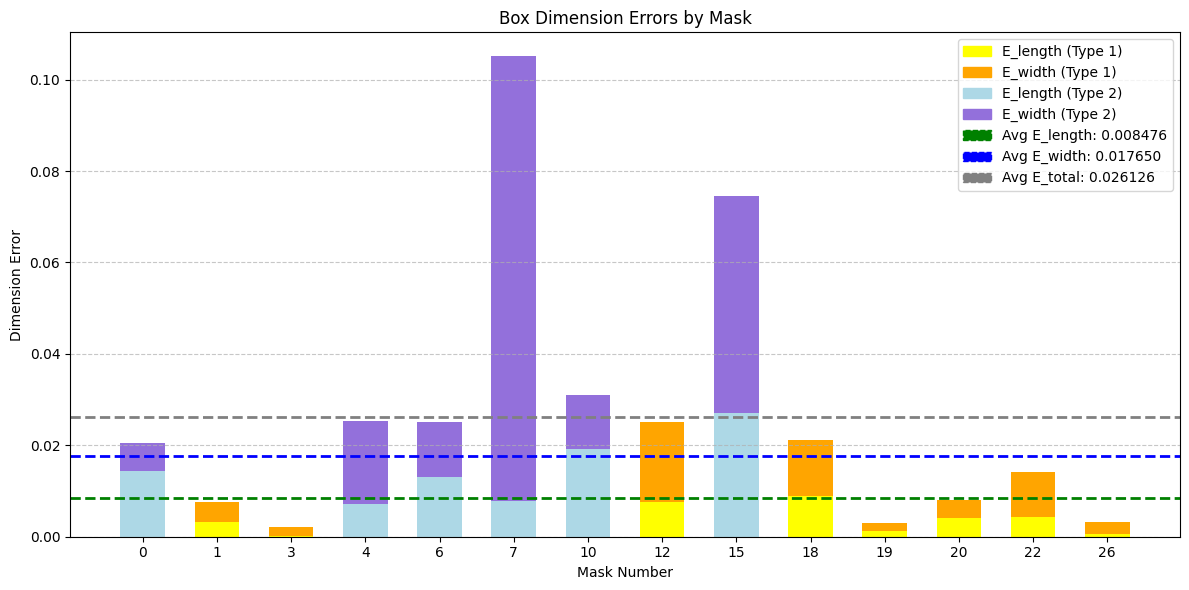

In [53]:
import matplotlib.patches as mpatches

# Sort masks
df = df.sort_values("mask_number")
mask_nums = df["mask_number"].tolist()
E_length = df["E_length"].tolist()
E_width = df["E_width"].tolist()
E_total = df["E_total"].tolist()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.6
x = range(len(mask_nums))

for i, mask in enumerate(mask_nums):
    length = E_length[i]
    width = E_width[i]
    
    if mask in box_type1:
        ax.bar(x[i], length, color='yellow', width=bar_width)
        ax.bar(x[i], width, bottom=length, color='orange', width=bar_width)
    elif mask in box_type2:
        ax.bar(x[i], length, color='lightblue', width=bar_width)
        ax.bar(x[i], width, bottom=length, color='mediumpurple', width=bar_width)
    else:
        ax.bar(x[i], length, color='gray', width=bar_width)
        ax.bar(x[i], width, bottom=length, color='darkgray', width=bar_width)

# Averages
avg_E_length = sum(E_length) / len(E_length)
avg_E_width = sum(E_width) / len(E_width)
avg_E_total = sum(E_total) / len(E_total)

ax.axhline(avg_E_length, color='green', linestyle='--', linewidth=2, label='Avg E_length')
ax.axhline(avg_E_width, color='blue', linestyle='--', linewidth=2, label='Avg E_width')
ax.axhline(avg_E_total, color='gray', linestyle='--', linewidth=2, label='Avg E_total')

# # Display average values on the right side
# x_pos = len(mask_nums) + -0.2
# ax.text(x_pos, avg_E_length, f"{avg_E_length:.4f}", color='green', va='center')
# ax.text(x_pos, avg_E_width, f"{avg_E_width:.4f}", color='blue', va='center')
# ax.text(x_pos, avg_E_total, f"{avg_E_total:.4f}", color='gray', va='center')

# Labels and legend
ax.set_xticks(x)
ax.set_xticklabels(mask_nums)
ax.set_xlabel("Mask Number")
ax.set_ylabel("Dimension Error")
ax.set_title("Box Dimension Errors by Mask")

# Custom legend
legend_patches = [
    mpatches.Patch(color='yellow', label='E_length (Type 1)'),
    mpatches.Patch(color='orange', label='E_width (Type 1)'),
    mpatches.Patch(color='lightblue', label='E_length (Type 2)'),
    mpatches.Patch(color='mediumpurple', label='E_width (Type 2)'),
    #mpatches.Patch(color='gray', label='E_length (Unknown Type)'),
    #mpatches.Patch(color='darkgray', label='E_width (Unknown Type)'),
    mpatches.Patch(color='green', label=f'Avg E_length: {avg_E_length:3f}', linestyle='--'),
    mpatches.Patch(color='blue', label=f'Avg E_width: {avg_E_width:3f}', linestyle='--'),
    mpatches.Patch(color='gray', label=f'Avg E_total: {avg_E_total:3f}', linestyle='--')
]

# Use handles directly to support linestyle in legend
ax.legend(handles=legend_patches, loc="upper right")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [41]:
# Calculate the percentage contribution of each E_total to the sum of all E_totals
percent_contrib = (E_totals / E_totals.sum()) * 100
print(percent_contrib)

[ 5.61972851  2.0507703   0.56976474  6.93751452  6.84100447 28.73402321
  8.45542903  6.86096264 20.36307465  5.76982489  0.84261753  2.17872131
  3.87270515  0.90385904]


### Other stuff

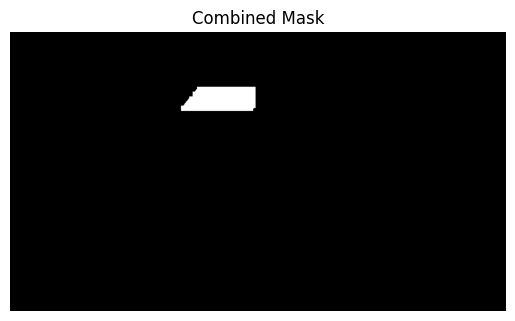

Combined mask saved to obj_FINAL1_data/permanent_data/YOLO_results/image_5/mask_10.npy


In [28]:
import numpy as np

# Paths to the two segmentation mask files
mask_path_1 = "obj_FINAL1_data/permanent_data/YOLO_results/image_5/mask_10.npy"
mask_path_2 = "obj_FINAL1_data/permanent_data/YOLO_results/image_5/mask_11.npy"

# Load the masks
mask1 = np.load(mask_path_1)
mask2 = np.load(mask_path_2)

# Combine the masks (e.g., by summing, or using logical OR)
# Assumes masks are binary (0 or 1). Adjust logic if using label IDs.
combined_mask = np.logical_or(mask1, mask2).astype(np.uint8)
# dilate combined_mask to fill small gaps
kernel = np.ones((3, 3), np.uint8)  # Adjust kernel size as needed
combined_mask = cv2.dilate(combined_mask, kernel, iterations=1)

# show the combined mask
plt.imshow(combined_mask, cmap='gray')
plt.axis('off')
plt.title("Combined Mask")
plt.show()
# Save the combined mask
combined_mask_path = "obj_FINAL1_data/permanent_data/YOLO_results/image_5/mask_10.npy"
np.save(combined_mask_path, combined_mask)

print(f"Combined mask saved to {combined_mask_path}")


In [3]:
# strip off the "_rgb" suffix (and extension) to get the common base
base = rgb_path.rsplit("_rgb", 1)[0]
depth_path      = base + "_depth.png"
yolo_csv_path   = base + "poses_bboxes.csv"   # matches "...15poses_bboxes.csv"
info_csv_path   = base + "_request.csv"


print("RGB  :", rgb_path)
print("Depth:", depth_path)

# print width and height of the image
img = cv2.imread(rgb_path)
h, w = img.shape[:2]
print(f"Image dimensions: {w} x {h}")


color = o3d.io.read_image(rgb_path)
depth = o3d.io.read_image(depth_path)

# Create RGBD image (adjust depth_scale and depth_trunc as needed)
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color, 
    depth, 
    depth_scale=1000.0, 
    depth_trunc=3.0, 
    convert_rgb_to_intensity=False
)

flip = np.array([[ 1,  0,  0, 0],
                 [ 0, -1,  0, 0],
                 [ 0,  0, -1, 0],
                 [ 0,  0,  0, 1]])

# 3×3 part for rotating frames or boxes
Rflip = flip[:3, :3]

# --- Generate point cloud ---
# your intrinsics
cam_intrinsics = [729.7567138671875, 729.7567138671875,
                  965.4871826171875, 553.424072265625]
fx, fy, cx, cy = cam_intrinsics

# construct custom pinhole intrinsic
intrinsic = o3d.camera.PinholeCameraIntrinsic(
    w, h,
    fx, fy, cx, cy
)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic, )
# Optionally flip the point cloud for correct orientation
pcd.transform(flip)

# --- Load grasp poses and bounding boxes from CSV ---
# read out all the columns except the first one if is_yolo is False

# —– loading your YOLO-style CSV —–
df = pd.read_csv(yolo_csv_path)
# if not is_yolo:
#     # drop the first column, whatever it’s called
#     df = df.drop(columns=['MaskNum'])

# prepare scene list
geoms = [pcd]

T_top = np.load("obj_FINAL1_data/permanent_data/top_view_frame_transform.npy")

# create and place the frame
frame_top = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
frame_top.transform(T_top)
frame_top.transform(flip)
geoms.append(frame_top)

label_spheres = []
label_colors = []  # optional, in case you want per-label colors
mask_ids = []      # to store mask numbers for later rendering


# create camera frame at the origin
camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
camera_frame.transform(flip) # only for correct visualization
geoms.append(camera_frame)

# --- Visualize all geometries ---
#o3d.visualization.draw_geometries(geoms)

save_dir = f"obj_FINAL1_evaluation/image_{image_num}/"
save_img_file1 = save_dir + "top_view_snapshot.png"
save_img_file2 = save_dir + "camera_view_snapshot.png"

# --- OFFSCREEN RENDER & COLORED SNAPSHOT ---
vis = o3d.visualization.Visualizer()
vis.create_window(width=1930, height=1930, visible=False)
# dark BG
opt = vis.get_render_option()
opt.background_color = np.array([0.5, 0.5, 0.5])
opt.point_size = 2.0
# 1) add the colored point cloud
vis.add_geometry(pcd)
vis.update_geometry(pcd)
# 2) add all grasp‐pose frames & boxes, but skip the top‐view arrow
for g in geoms:
    if g is frame_top or g is camera_frame:
        continue
    vis.add_geometry(g)
    vis.update_geometry(g)
# 3) set view to your saved top‐view pose
ctr = vis.get_view_control()
param = ctr.convert_to_pinhole_camera_parameters()
cam2world_top = flip @ T_top
param.extrinsic = np.linalg.inv(cam2world_top)
ctr.convert_from_pinhole_camera_parameters(param)
# 4) render & capture
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image(save_img_file1, do_render=True)

# now capture original camera-frame view
# reset extrinsic to identity (camera at world origin)
# flip the camera frame to match the point cloud
param.extrinsic = flip @ np.eye(4)
ctr.convert_from_pinhole_camera_parameters(param)

# re-render and grab
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image(save_img_file2, do_render=True)

vis.destroy_window()

# load the saved image
img = cv2.imread(save_img_file1)
#img2 = cv2.imread(save_img_file2)
# rotate 180° (flip both axes)
img_rot = cv2.flip(img, -1)
#img2_rot = cv2.flip(img2, -1)
# overwrite the snapshot with the rotated version
cv2.imwrite(save_img_file1, img_rot)
#cv2.imwrite(save_img_file2, img2_rot)
print("Saved camera view and top view snapshots.")

RGB  : new_data/2025_02_24___13_00_01_rgb.jpg
Depth: new_data/2025_02_24___13_00_01_depth.png
Image dimensions: 1920 x 1080
Saved camera view and top view snapshots.


## Optimizer Logs

In [28]:
image_num = 1
mask_number = 0
date_time = "20250512_114220"
saved_dir = f"obj_FINAL1_evaluation/image_{image_num}/mask_{mask_number}_experim_{date_time}" + "/optimizer_log.csv"

df = pd.read_csv(saved_dir)

In [29]:
print("Columns in the CSV file:", df.columns.tolist())

Columns in the CSV file: ['iter', 'E_line', 'E_pose', 'E_plane', 'E_total', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22']


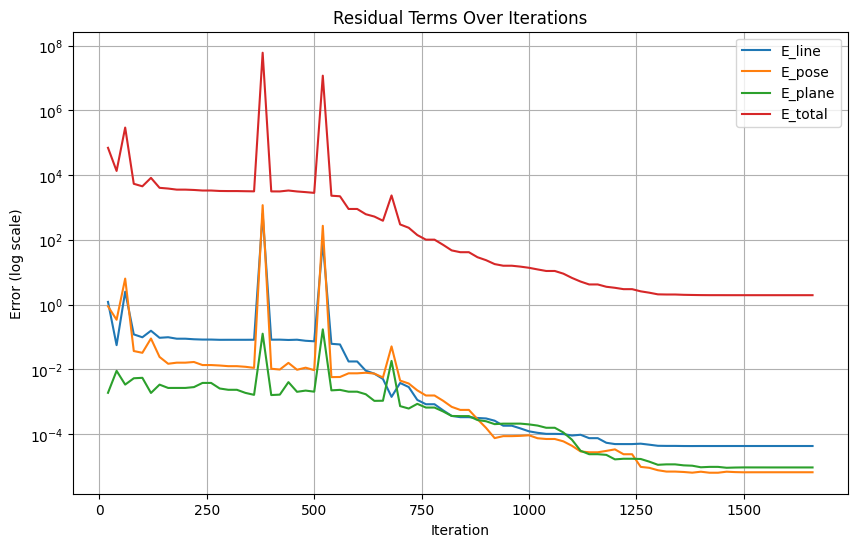

In [30]:
# 2) Plot residuals vs iteration
ax = df.plot(
    x="iter",
    y=["E_line","E_pose","E_plane","E_total"],
    figsize=(10, 6),
    title="Residual Terms Over Iterations"
)
ax.set_xlabel("Iteration")
ax.set_ylabel("Error (log scale)")
ax.set_yscale("log")
plt.grid(True)
plt.show()

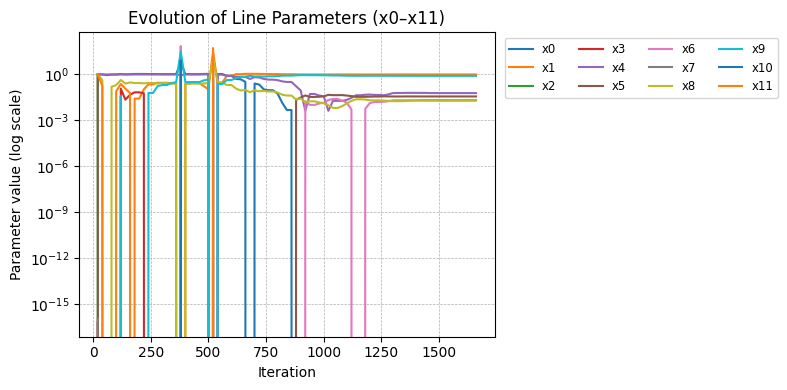

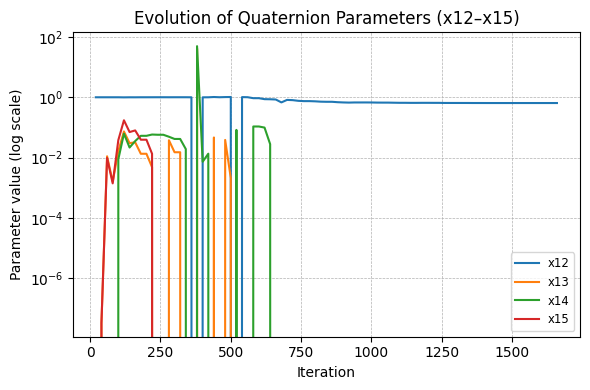

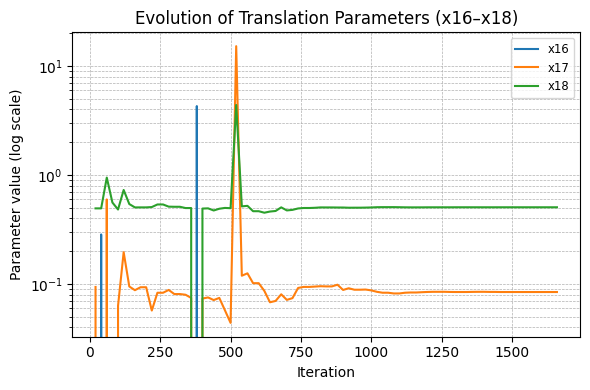

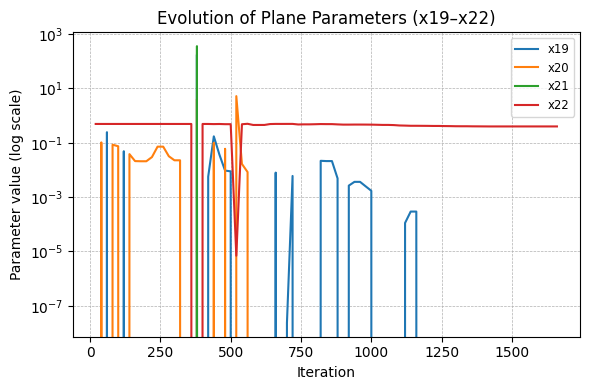

In [21]:

# Define parameter groups
line_params    = [f"x{i}" for i in range(0, 12)]
quat_params    = [f"x{i}" for i in range(12, 16)]
trans_params   = [f"x{i}" for i in range(16, 19)]
plane_params   = [f"x{i}" for i in range(19, 23)]

# Make sure 'iter' exists
if "iter" not in df.columns:
    df["iter"] = df.index

# Plot 1: All line parameters (x0–x11)
fig, ax = plt.subplots(figsize=(8, 4))
for col in line_params:
    ax.plot(df["iter"], df[col], label=col)
ax.set_yscale("log")
ax.set_title("Evolution of Line Parameters (x0–x11)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter value (log scale)")
ax.legend(ncol=4, fontsize="small", bbox_to_anchor=(1.01, 1), loc="upper left")
ax.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

# Plot 2: Quaternion parameters (x12–x15)
fig, ax = plt.subplots(figsize=(6, 4))
for col in quat_params:
    ax.plot(df["iter"], df[col], label=col)
ax.set_yscale("log")
ax.set_title("Evolution of Quaternion Parameters (x12–x15)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter value (log scale)")
ax.legend(fontsize="small")
ax.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

# Plot 3: Translation parameters (x16–x18)
fig, ax = plt.subplots(figsize=(6, 4))
for col in trans_params:
    ax.plot(df["iter"], df[col], label=col)
ax.set_yscale("log")
ax.set_title("Evolution of Translation Parameters (x16–x18)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter value (log scale)")
ax.legend(fontsize="small")
ax.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

# Plot 4: Plane parameters (x19–x22)
fig, ax = plt.subplots(figsize=(6, 4))
for col in plane_params:
    ax.plot(df["iter"], df[col], label=col)
ax.set_yscale("log")
ax.set_title("Evolution of Plane Parameters (x19–x22)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter value (log scale)")
ax.legend(fontsize="small")
ax.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

C:\Users\Startklar\AppData\Local\Temp\ipykernel_32660\3761079346.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("coolwarm")
C:\Users\Startklar\AppData\Local\Temp\ipykernel_32660\3761079346.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for cbar


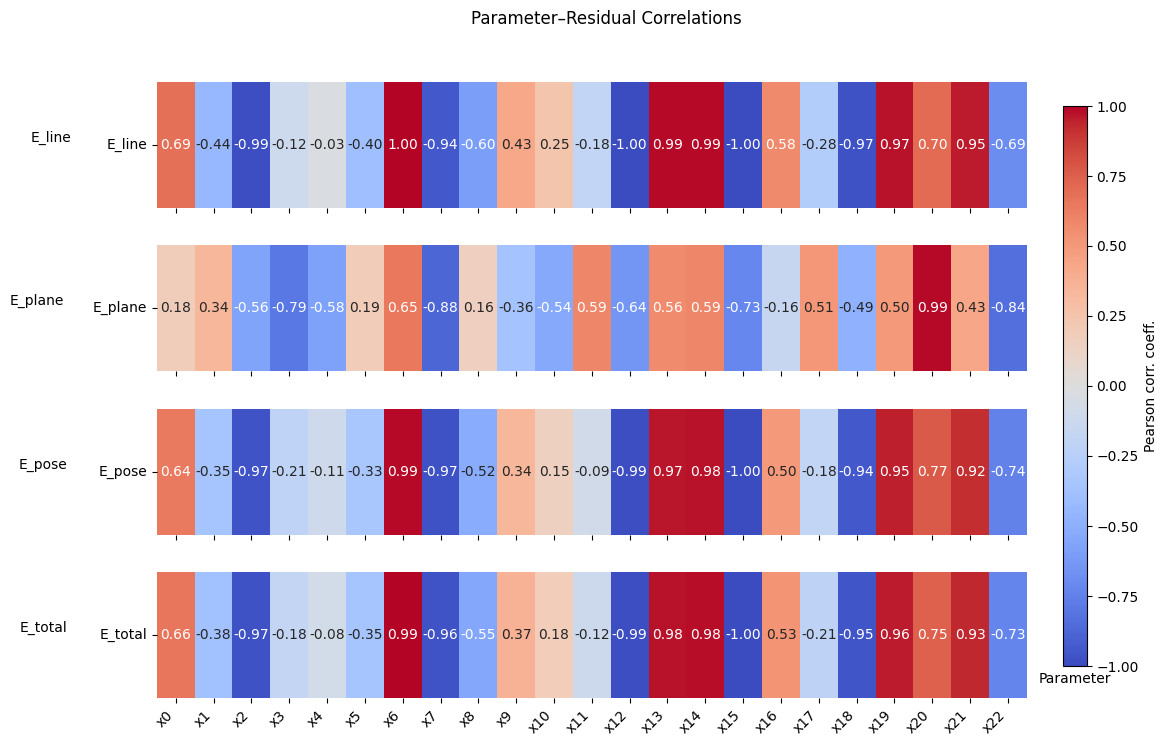

In [27]:

# 2) Identify parameter columns
param_cols = [c for c in df.columns if c.startswith("x")]

# 3) Compute the correlation matrix
corr = df[param_cols + ["E_total","E_line","E_pose","E_plane"]].corr()

# 4) Prepare figure + axes, leaving margin on right for colorbar
fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(12, 8), sharex=True,
    gridspec_kw={'right': 0.85, 'hspace': 0.3}
)

terms = ["E_line", "E_plane", "E_pose", "E_total"]
vmin, vmax = -1, 1
cmap = get_cmap("coolwarm")
norm = Normalize(vmin=vmin, vmax=vmax)

# 5) Plot each heatmap without its own colorbar
for ax, term in zip(axes, terms):
    row = corr.loc[param_cols, term].to_frame().T
    sns.heatmap(
        row,
        ax=ax,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        cbar=False,                 # disable individual cbar
        xticklabels=param_cols,
        yticklabels=[term]
    )
    ax.set_ylabel(term, rotation=0, labelpad=40)
    ax.tick_params(axis="y", rotation=0)

# 6) Add a single shared colorbar on the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for older Matplotlib
fig.colorbar(sm, cax=cbar_ax, label="Pearson corr. coeff.")

# 7) Final touches
axes[-1].set_xticklabels(param_cols, rotation=45, ha="right")
plt.xlabel("Parameter")
plt.suptitle("Parameter–Residual Correlations", y=0.97)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for cbar

# 8) Save and/or show
fig.savefig("param_residual_correlations.png", dpi=300)
plt.show()


Weights tuning

In [31]:
sig_line  = df["E_line"].std()
sig_pose  = df["E_pose"].std()
sig_plane = df["E_plane"].std()
print(f"Standard deviation of E_line: {sig_line}")
print(f"Standard deviation of E_pose: {sig_pose}")
print(f"Standard deviation of E_plane: {sig_plane}")

Standard deviation of E_line: 70.68589911362189
Standard deviation of E_pose: 133.37917192318022
Standard deviation of E_plane: 0.023240224385570874


In [33]:
inv = np.array([1/sig_line, 1/sig_pose, 1/sig_plane])
weights = inv / inv.sum()
# print in decimal format
weights = [f"{w:.4f}" for w in weights]
print(f"Weights: {weights}")

Weights: ['0.0003', '0.0002', '0.9995']


## Open3D Scenes

In [70]:
import os
import json
import numpy as np
import open3d as o3d

def load_open3d_scene(folder_path):
    """
    Reads all geometries and camera parameters from an Open3D scene folder created
    by save_open3d_scene(). Returns (geometries, camera_params).
    """
    geometries    = []
    camera_params = None

    for fname in sorted(os.listdir(folder_path)):
        path = os.path.join(folder_path, fname)

        # 1) TriangleMesh files → mesh_*.ply
        if fname.startswith("mesh_") and fname.endswith(".ply"):
            mesh = o3d.io.read_triangle_mesh(path)
            mesh.compute_vertex_normals()
            geometries.append(mesh)

        # 2) PointCloud files → pointcloud_*.ply
        elif fname.startswith("pointcloud_") and fname.endswith(".ply"):
            pc = o3d.io.read_point_cloud(path)
            geometries.append(pc)

        # 3) LineSet files → lineset_*.json
        elif fname.startswith("lineset_") and fname.endswith(".json"):
            with open(path, "r") as f:
                data = json.load(f)
            pts   = np.asarray(data["points"])
            lines = np.asarray(data["lines"])
            ls = o3d.geometry.LineSet()
            ls.points = o3d.utility.Vector3dVector(pts)
            ls.lines  = o3d.utility.Vector2iVector(lines)
            if data.get("colors") is not None:
                cols = np.asarray(data["colors"])
                ls.colors = o3d.utility.Vector3dVector(cols)
            geometries.append(ls)

        # 4) Camera parameters → camera.json
        elif fname == "camera.json":
            camera_params = o3d.io.read_pinhole_camera_parameters(path)

    return geometries, camera_params

def visualize_open3d_scene(folder_path):
    """
    Loads the scene from folder_path and visualizes it with the saved camera parameters.
    """
    geometries, camera_params = load_open3d_scene(folder_path)

    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=f"Scene: {os.path.basename(folder_path)}")
    for geo in geometries:
        vis.add_geometry(geo)

    if camera_params is not None:
        ctr = vis.get_view_control()
        ctr.convert_from_pinhole_camera_parameters(camera_params)

    vis.run()
    vis.destroy_window()

# ─── Example usage ───────────────────────────────────────────────
image_num = 2
mask_number = 0
date_time = "20250512_184216"
scene_num = 2
scene_dir = f"obj_FINAL1_evaluation/image_{image_num}/mask_{mask_number}_experim_{date_time}/open3d_scene_{scene_num}"
visualize_open3d_scene(scene_dir)


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [ ]:
import os
import json
import numpy as np
import open3d as o3d

def load_open3d_scene(folder_path):
    """
    Reads all geometries and camera parameters from an Open3D scene folder created
    by save_open3d_scene(). Returns (geometries, camera_params).
    """
    geometries    = []
    camera_params = None

    for fname in sorted(os.listdir(folder_path)):
        path = os.path.join(folder_path, fname)

        # TriangleMesh → .ply
        if fname.startswith("mesh_") and fname.endswith(".ply"):
            mesh = o3d.io.read_triangle_mesh(path)
            mesh.compute_vertex_normals()
            geometries.append(mesh)

        # PointCloud → .ply
        elif fname.startswith("pointcloud_") and fname.endswith(".ply"):
            pc = o3d.io.read_point_cloud(path)
            geometries.append(pc)

        # LineSet → .json
        elif fname.startswith("lineset_") and fname.endswith(".json"):
            with open(path, "r") as f:
                data = json.load(f)
            ls = o3d.geometry.LineSet()
            ls.points = o3d.utility.Vector3dVector(np.asarray(data["points"]))
            ls.lines  = o3d.utility.Vector2iVector(np.asarray(data["lines"]))
            if data.get("colors") is not None:
                ls.colors = o3d.utility.Vector3dVector(np.asarray(data["colors"]))
            geometries.append(ls)

        # Camera params → camera.json
        elif fname == "camera.json":
            camera_params = o3d.io.read_pinhole_camera_parameters(path)

    return geometries, camera_params

# ─── Usage: ────────────────────────────────────────────────────────────

scene_folder = "runs/open3d_scene_1"
geoms, cam_params = load_open3d_scene(scene_folder)

# Unpack into meaningful variable names (same order as saved)
cam_frame        = geoms[0]
box_frame_est    = geoms[1]
plane_mesh_est   = geoms[2]
seg_cloud        = geoms[3]
quad_obs_est     = geoms[4]
quad_mod_est     = geoms[5]
# ... continue unpacking if you have more ...

# Now you can easily comment/uncomment which to visualize:
to_show = [
    cam_frame,
    # seg_cloud,
    box_frame_est,
    plane_mesh_est,
    quad_obs_est,
    # quad_mod_est,
]

# Visualize with the saved camera parameters
vis = o3d.visualization.Visualizer()
vis.create_window(window_name=os.path.basename(scene_folder))
for geo in to_show:
    vis.add_geometry(geo)

if cam_params is not None:
    ctr = vis.get_view_control()
    ctr.convert_from_pinhole_camera_parameters(cam_params)

vis.run()
vis.destroy_window()


# ─── Example usage ───────────────────────────────────────────────
image_num = 2
mask_number = 0
date_time = "20250512_184216"
scene_num = 1

scene_dir = f"obj_FINAL1_evaluation/image_{image_num}/mask_{mask_number}_experim_{date_time}/open3d_scene_{scene_num}"
visualize_open3d_scene(scene_dir)



[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [67]:
import os
import json
import numpy as np
import open3d as o3d

def load_scene_geometries(folder_path):
    """
    Load all geometries saved with save_open3d_scene, returning them
    in a list ordered by their original index.  You can then pick
    and choose which to visualize by commenting/uncommenting.
    """
    geom_dict = {}
    for fname in os.listdir(folder_path):
        path = os.path.join(folder_path, fname)
        # TriangleMesh → mesh_{i}.ply
        if fname.startswith("mesh_") and fname.endswith(".ply"):
            idx = int(fname.split("_")[1].split(".")[0])
            mesh = o3d.io.read_triangle_mesh(path)
            mesh.compute_vertex_normals()
            geom_dict[idx] = mesh
        # PointCloud → pointcloud_{i}.ply
        elif fname.startswith("pointcloud_") and fname.endswith(".ply"):
            idx = int(fname.split("_")[1].split(".")[0])
            pc = o3d.io.read_point_cloud(path)
            geom_dict[idx] = pc
        # LineSet → lineset_{i}.json
        elif fname.startswith("lineset_") and fname.endswith(".json"):
            idx = int(fname.split("_")[1].split(".")[0])
            with open(path, "r") as f:
                data = json.load(f)
            ls = o3d.geometry.LineSet(
                points=o3d.utility.Vector3dVector(np.asarray(data["points"])),
                lines=o3d.utility.Vector2iVector(np.asarray(data["lines"]))
            )
            if data.get("colors") is not None:
                ls.colors = o3d.utility.Vector3dVector(np.asarray(data["colors"]))
            geom_dict[idx] = ls
    # return list in index order
    return [geom_dict[i] for i in sorted(geom_dict.keys())]



# ─── Usage ────────────────────────────────────────────────────────────────
scene_dir = f"obj_FINAL1_evaluation/image_{image_num}/mask_{mask_number}_experim_{date_time}/open3d_scene_{scene_num}"
all_geoms = load_scene_geometries(scene_dir)

# Now build a list of exactly the geometries you want to show.
# Comment out any you do NOT want in the visualization.
geometries_to_show = [
    all_geoms[0],   # cam_frame
    all_geoms[1],   # box_frame_est
    all_geoms[2],   # plane_mesh_est
    all_geoms[3],   # seg_cloud
    all_geoms[4],   # quad_obs_est
    all_geoms[5],   # quad_mod_est
    *all_geoms[6:9],  # axis_spheres_est
   # *all_geoms[9:13], # obs_spheres_est
   # *all_geoms[13:17],# mod_spheres_est
   # all_geoms[17],  # 
   #all_geoms[18],  # plane_mesh_init
   #all_geoms[19],  # quad_obs_init
   all_geoms[20],  # box_frame_init
   #*all_geoms[21:24], # plane
   *all_geoms[24:28], # obs_spheres_init
    #*all_geoms[28:32]  # obs_spheres_init
]

# If you also saved and want to reuse the camera:
cam_params_path = os.path.join(saved_dir, "camera.json")
if os.path.exists(cam_params_path):
    cam_params = o3d.io.read_pinhole_camera_parameters(cam_params_path)
else:
    cam_params = None

vis = o3d.visualization.Visualizer()
vis.create_window()
for geo in geometries_to_show:
    vis.add_geometry(geo)
if cam_params is not None:
    ctr = vis.get_view_control()
    ctr.convert_from_pinhole_camera_parameters(cam_params)
vis.run()
vis.destroy_window()


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
